# Facies classification using Machine Learning

#### Bird Team: PG+AC

In [1]:
%matplotlib inline
import pandas as pd
from pandasql import sqldf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score,LeavePGroupsOut, LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, accuracy_score, recall_score, precision_score
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
pd.options.mode.chained_assignment = None

In [2]:
filename = './../training_data.csv'
training_data = pd.read_csv(filename)
print(set(training_data["Well Name"]))
training_data.head()

set(['SHRIMPLIN', 'Recruit F9', 'SHANKLE', 'CHURCHMAN BIBLE', 'NOLAN', 'NEWBY', 'LUKE G U', 'CROSS H CATTLE'])


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [3]:
well_data = pd.read_csv('./../validation_data_nofacies.csv')
print(set(well_data["Well Name"]))
print(well_data.shape)
well_data.head()

set(['CRAWFORD', 'STUART'])
(830, 10)


,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911


In [4]:
# concat train and test for processing 
well_data["origin"] = 'test'
training_data["origin"] = 'train'
df = pd.concat([well_data,training_data],axis=0,ignore_index=True)[list(training_data.columns)]
df['Well Name'] = df['Well Name'].astype('category')
df.head(10)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,origin
0,NaN,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000,test
1,NaN,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978,test
2,NaN,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956,test
3,NaN,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933,test
4,NaN,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911,test
5,NaN,A1 SH,STUART,2810.5,73.955,0.667,6.9,12.25,3.086,1,0.889,test
6,NaN,A1 SH,STUART,2811.0,77.962,0.674,6.5,12.45,3.092,1,0.867,test
7,NaN,A1 SH,STUART,2811.5,83.894,0.667,6.3,12.65,3.123,1,0.844,test
8,NaN,A1 SH,STUART,2812.0,84.424,0.653,6.7,13.05,3.121,1,0.822,test
9,NaN,A1 SH,STUART,2812.5,83.160,0.642,7.3,12.95,3.127,1,0.800,test


In [5]:
# add some features based on the well data. 

# nb points : can be correlated with how soft soil is ? 
print("session")
sessionsize = df.groupby(["Well Name",'Formation']).size().reset_index()
sessionsize.columns =  ["Well Name",'Formation','formation_size']
df = pd.merge(df,sessionsize,how='left',on = ["Well Name",'Formation'])

# depth : 
print("depth")
sessionsize = df.groupby(["Well Name",'Formation'])["Depth"].min().reset_index()
sessionsize.columns =  ["Well Name",'Formation','minimum_depth']
df = pd.merge(df,sessionsize,how='left',on = ["Well Name",'Formation'])

sessionsize = df.groupby(["Well Name",'Formation'])["Depth"].max().reset_index()
sessionsize.columns =  ["Well Name",'Formation','maximum_depth']
df = pd.merge(df,sessionsize,how='left',on = ["Well Name",'Formation'])

df['formation_depth'] = df["maximum_depth"] - df["minimum_depth"]

df["soft_indic"] = df['formation_depth'] / df["formation_size"]

# add avgs of feat
print("add avgs of feat")
list_to_avg = ['Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
for val in list_to_avg : 
    df[val + "_min"] = df.groupby(["Well Name",'Formation'])[val].transform(np.min)
    df[val + "_max"] = df.groupby(["Well Name",'Formation'])[val].transform(np.max)
    df[val + "_mean"] = df.groupby(["Well Name",'Formation'])[val].transform(np.mean)
    df[val + "_var"] = df.groupby(["Well Name",'Formation'])[val].transform(np.var) 

# add distances feat. = an attempt at regulariation.
print("add distances feat.")
for val in list_to_avg : 
    df[val + "_min_dist"] = df[val] -df[val + "_min"]
    df[val + "_max_dist"] =  df[val] -df[val + "_max"]
    df[val + "_mean_dist"] =  df[val] -df[val + "_mean"]
    
# add lag and lead !
print("lag lead")
list_to_lag = ['Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
for val in list_to_lag:
    for lag in range(1,11):
        df[val+'_lag_'+str(lag)]=df[val]-df.groupby("Well Name")[val].shift(periods=lag)
        df[val+'_lead_'+str(lag)]=df[val]-df.groupby("Well Name")[val].shift(periods=-lag)

# adding some Formation lag and lead. 
for lag in range(1,3):
    df['Formation'+'_lag_'+str(lag)]=df.groupby("Well Name")['Formation'].shift(periods=lag)
    df['Formation'+'_lead_'+str(lag)]=df.groupby("Well Name")['Formation'].shift(periods=-lag)
    df['Formation'+'_lag_'+str(lag) + 'equal'] = (df['Formation'+'_lag_'+str(lag)] == df["Formation"]).astype(int)
    df['Formation'+'_lead_'+str(lag) + 'equal'] = (df['Formation'+'_lead_'+str(lag)] == df["Formation"]).astype(int) 

print("rolling")
#Add rolling features
list_to_roll = ['Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M','RELPOS']
window_size = [5,10,15,20,50]
for w in window_size:
    for val in list_to_roll:
        df[val+'_rollingmean_'+str(w)]=df.groupby("Well Name")[val].apply(
            lambda x:x.rolling(window=w,center=True).mean())
        df[val+'_rollingmax_'+str(w)]=df.groupby("Well Name")[val].apply(
            lambda x:x.rolling(window=w,center=True).max())
        df[val+'_rollingmin_'+str(w)]=df.groupby("Well Name")[val].apply(
            lambda x:x.rolling(window=w,center=True).min())
        df[val+'_rollingstd_'+str(w)]=df.groupby("Well Name")[val].apply(
            lambda x:x.rolling(window=w,center=True).std())
        
print("special window features for NM_M")
def NM_M_distance(x,how,target):
    length = len(x)
    rank = np.empty(length)
    count = -1
    NM_M = x["NM_M"].values
    if how=="up":
        order = range(length)
    elif how=="down":
        order = range(length-1,-1,-1)
    for i in order:
        if ((NM_M[i] != target) & (count>-1)):
            count+=1
            rank[i] += count
        elif NM_M[i] == target:
            count=0
        else:
            rank[i] = count
    rank = pd.DataFrame(rank.astype(int), columns=["NM_M_Rank_Target_+"+str(target)+"_"+how], index = x.index)
    return(rank)
df["NM_M_Rank_Target_1_up"]=df.groupby(["Well Name"]).apply(NM_M_distance,how="up",target=1)
df["NM_M_Rank_Target_2_up"]=df.groupby(["Well Name"]).apply(NM_M_distance,how="up",target=2)
df["NM_M_Rank_Target_1_down"]=df.groupby(["Well Name"]).apply(NM_M_distance,how="down",target=1)
df["NM_M_Rank_Target_2_down"]=df.groupby(["Well Name"]).apply(NM_M_distance,how="down",target=2)

print("filling na")
df = df.groupby(["Well Name"], as_index=False).apply(lambda group: group.bfill())
df = df.groupby(["Well Name"], as_index=False).apply(lambda group: group.ffill())

print("Vectorizing Formation text data")
from sklearn.feature_extraction.text import CountVectorizer
list_formation = ['Formation',
 'Formation_lag_1',
 'Formation_lead_1',
 'Formation_lag_2',
 'Formation_lead_2']
for l in list_formation:
    cv = CountVectorizer()
    counts = cv.fit_transform(df[l].values)
    cols = [c+"_"+l for c in cv.get_feature_names()]
    counts = pd.DataFrame(counts.toarray(),columns = cols)
    df = df.drop(l,axis = 1)
    df = pd.concat([df,counts],axis=1)

print("Finished preparing data. Now ready for ML ignition!")

session
depth
add avgs of feat
add distances feat.
lag lead
rolling
special window features for NM_M
filling na
Vectorizing Formation text data
Finished preparing data. Now ready for ML ignition!


In [189]:
#tokeep =['Facies','origin','Formation','Formation_lag_1','Formation_lead_1','Formation_lag_2','Formation_lead_2',
#         'Well Name','Depth','GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M','RELPOS']
#nums = ['Depth','GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M','RELPOS']
#tokeep = tokeep + [x+'_lag_1' for x in nums] +[x+'_lead_1' for x in nums]
#df = df[tokeep]

## CV performance

In [6]:
clf = RandomForestClassifier(
    max_depth = 10,
    n_estimators = 1000,
    max_features=0.1,
    min_samples_leaf=25,
    min_samples_split=50,
    class_weight='balanced',
    oob_score=True,
)

In [92]:
ytrain = df[(df['origin']=='train')&(df['Well Name']<>'NOLAN')]['Facies']
yvalid = df[(df['origin']=='train')&(df['Well Name']=='NOLAN')]['Facies']
xtrain = df[(df['origin']=='train')&(df['Well Name']<>'NOLAN')].drop(['Well Name','origin','Facies'],axis=1)
xvalid = df[(df['origin']=='train')&(df['Well Name']=='NOLAN')].drop(['Well Name','origin','Facies'],axis=1)

In [93]:
clf.fit(xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=0.1,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=25, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [94]:
preds = clf.predict(xvalid)
from sklearn.metrics import classification_report
print(clf.oob_score_)
print classification_report(yvalid, preds)

0.780262690806
             precision    recall  f1-score   support

        1.0       0.00      0.00      0.00         4
        2.0       0.83      0.68      0.75       118
        3.0       0.62      0.84      0.71        68
        4.0       0.24      0.14      0.18        28
        5.0       0.48      0.51      0.49        47
        6.0       0.19      0.13      0.16        30
        7.0       0.00      0.00      0.00         4
        8.0       0.75      0.47      0.57       116
        9.0       0.00      0.00      0.00         0

avg / total       0.63      0.54      0.57       415



In [95]:
# this time let's use all the training set 
groups = df[(df['origin']=='train')]["Well Name"]
ytrain = df[(df['origin']=='train')]['Facies']
yvalid = df[(df['origin']=='test')]['Facies']
xtrain = df[(df['origin']=='train')].drop(['Well Name','origin','Facies'],axis=1)
xvalid = df[(df['origin']=='test')].drop(['Well Name','origin','Facies'],axis=1)

In [96]:
cv=LeaveOneGroupOut().split(xtrain, ytrain, groups)
y_pred = cross_val_predict(clf, xtrain, ytrain, cv=cv, n_jobs=-1)

In [97]:
print(classification_report(ytrain, y_pred))

             precision    recall  f1-score   support

        1.0       0.64      0.37      0.47       259
        2.0       0.59      0.60      0.59       738
        3.0       0.57      0.67      0.62       615
        4.0       0.48      0.69      0.56       184
        5.0       0.36      0.23      0.28       217
        6.0       0.49      0.43      0.45       462
        7.0       0.32      0.43      0.36        98
        8.0       0.52      0.54      0.53       498
        9.0       0.67      0.65      0.66       161

avg / total       0.54      0.54      0.53      3232



In [98]:
importances = clf.feature_importances_ 
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
feature = list(xtrain.columns.values)
for f in range(xtrain.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], feature[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 381 PE_rollingmean_50 (0.022994)
2. feature 39 NM_M_mean (0.022056)
3. feature 382 PE_rollingmax_50 (0.019726)
4. feature 404 sh_Formation (0.018786)
5. feature 403 lm_Formation (0.017266)
6. feature 257 NM_M_rollingmean_5 (0.017182)
7. feature 350 PE_rollingmax_20 (0.016063)
8. feature 239 GR_rollingmin_5 (0.014930)
9. feature 396 NM_M_Rank_Target_2_down (0.014756)
10. feature 6 NM_M (0.014075)
11. feature 318 PE_rollingmax_15 (0.014054)
12. feature 360 RELPOS_rollingstd_20 (0.012051)
13. feature 1 GR (0.011980)
14. feature 349 PE_rollingmean_20 (0.011912)
15. feature 2 ILD_log10 (0.011767)
16. feature 328 RELPOS_rollingstd_15 (0.010642)
17. feature 317 PE_rollingmean_15 (0.010528)
18. feature 321 NM_M_rollingmean_15 (0.010520)
19. feature 21 ILD_log10_min (0.009969)
20. feature 289 NM_M_rollingmean_10 (0.009950)
21. feature 237 GR_rollingmean_5 (0.009696)
22. feature 285 PE_rollingmean_10 (0.009675)
23. feature 241 ILD_log10_rollingmean_5 (0.009555)
24. fe

## Apply to test

In [21]:
# this time let's use all the training set 
ytrain = df[(df['origin']=='train')]['Facies']
yvalid = df[(df['origin']=='test')]['Facies']
xtrain = df[(df['origin']=='train')].drop(['Well Name','origin','Facies'],axis=1)
xvalid = df[(df['origin']=='test')].drop(['Well Name','origin','Facies'],axis=1)
well_name_valid = df.loc[(df['origin']=='test'),"Well Name"]

In [8]:
clf.fit(xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=0.1,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=25, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [24]:
preds = clf.predict(xvalid.values)

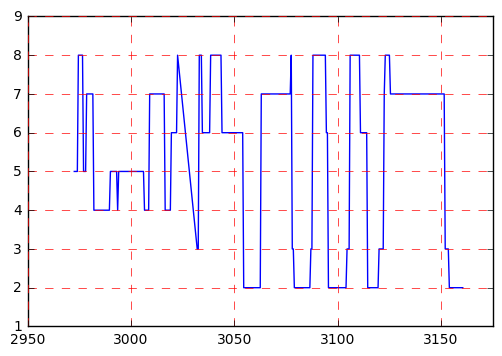

In [40]:
well = "CRAWFORD"
depth = xvalid.loc[well_name_valid== well ,"Depth"]
predictions = pd.Series(preds).loc[well_name_valid==well]
plt.plot(depth,predictions)
plt.axis([2950,3175, 1, 9])
plt.grid(b=True, which='major', color='r', linestyle='--')
plt.show()

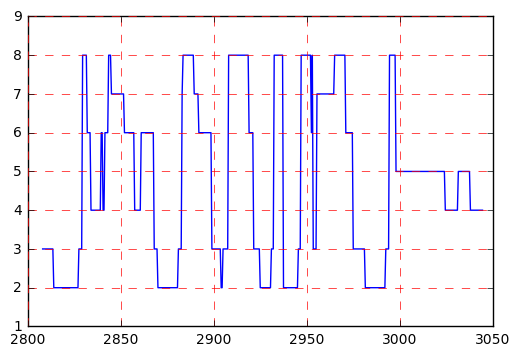

In [43]:
well = "STUART"
depth = xvalid.loc[well_name_valid== well ,"Depth"]
predictions = pd.Series(preds).loc[well_name_valid==well]
plt.plot(depth,predictions)
plt.axis([2800,3050, 1, 9])
plt.grid(b=True, which='major', color='r', linestyle='--')
plt.show()

In [102]:
xvalid['Facies']=preds
xvalid.to_csv('XmasPreds_3.csv')